In [1135]:
# Importing required libraries
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import norm
from random import random

In [1136]:
# Настройка графиков и таблиц

sns.set()
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

## Функции, использованные для предобработки датасета

In [1137]:
# Функция определения границ выбросов
def get_boards(series):
    Q1 = pd.Series.quantile(series,q=0.25)
    Q3 = pd.Series.quantile(series,q=0.75)
    IQR = Q3 - Q1
    outlier_boards = [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    
    return outlier_boards

In [1138]:
# Функция поиска None и пробельных пропусков
def find_nulls(series):
    answer_dict = {
            'skip_nan': 0, 
            'skip_space': 0,
            'all_skips': 0,
            'frac_skips': 0
            }
    if len(series) > 0:
        #Число пустых значений:
        answer_dict['skip_nan'] = len(series[series.isna()])
        # Число пробельных пропусков:
        answer_dict['skip_space'] = len(series[series.astype('str').str.strip() == ''])
        # Суммарное количество пропусков
        answer_dict['all_skips'] = answer_dict['skip_nan'] + answer_dict['skip_space']
        # Доля пропусков от размера Серии
        answer_dict['frac_skips'] = answer_dict['all_skips']/len(series)

    return answer_dict

In [1139]:
# Функция отображения состава КАТЕГОРИАЛЬНОГО столбца
def display_cat(df, column, disp=True, plot=True, rot=0):

    answer_dict = {
        'nulls': {},
        'df': ''
    }

    # Имеются ли None-элементы или пробельные пропуски
    nulls_dict = find_nulls(df[column])
    answer_dict['nulls'] = nulls_dict

    # Оценим состав данной колонки
    answer_dict['df'] = pd.DataFrame({'total': df[column].value_counts(), 
                        'proportion': df[column].value_counts(normalize=True)})
    
    # ВЫВОД РЕЗУЛЬТАТОВ АНАЛИЗА КОЛОНКИ
    if disp:
        # Данные по Null:
        if nulls_dict['skip_nan'] == 0:
            print('None-пропуски отсутствуют.')
        else:
            print(f"Количество None-пропусков: {nulls_dict['skip_nan']}")
        
        if nulls_dict['skip_space'] == 0:
            print('Пробельные пропуски отсутствуют.')
        else:
            print(f"Количество пробельных пропусков: {nulls_dict['skip_space']}")        
    
        if nulls_dict['frac_skips'] > 0:
            print(f"\nДоля пропусков от объёма выборки: {round(nulls_dict['frac_skips']*100, 1)}%")

        # Вывод датафрейма
        print('\nСостав колонки ' + column)
        display(answer_dict['df'])
    
    if plot:
        #Построим распределение
        df[column].value_counts(normalize=True).plot(kind='bar',
                                                        grid= True,
                                                        title=column + " proportion",
                                                        legend=False) 
        plt.xticks(rotation=rot)
    
    return answer_dict

In [1140]:
# Функция отображения состава ЧИСЛОВОГО столбца
def display_num(df, column, disp=True, plot=True, bin_koef=1):
    answer_dict = {
        'nulls': {},
        'df': '',
        'outliers': ''
    }    
    
    # Имеются ли None-элементы или пробельные пропуски
    nulls_dict = find_nulls(df[column])
    answer_dict['nulls'] = nulls_dict

    # Статистическое описание колонки
    answer_dict['df'] = pd.DataFrame(df[column].describe())  
    
    # Определим границы выбросов, и выведем данные, соответствующие этому диапазону в гистограмму
    boards = get_boards(df[column])

    # Значение и количество выбросов
    out_ser = df[(df[column] > boards[1])| \
                                (df[column] < boards[0])][column]
    answer_dict['outliers'] = pd.DataFrame({'outliers_count': out_ser.value_counts()})

    # ВЫВОД РЕЗУЛЬТАТОВ АНАЛИЗА КОЛОНКИ
    if disp:
        # Данные по Null:
        if nulls_dict['skip_nan'] == 0:
            print('None-пропуски отсутствуют.')
        else:
            print(f"Количество None-пропусков: {nulls_dict['skip_nan']}")
        
        if nulls_dict['skip_space'] == 0:
            print('Пробельные пропуски отсутствуют.')
        else:
            print(f"Количество пробельных пропусков: {nulls_dict['skip_space']}")        
    
        if nulls_dict['frac_skips'] > 0:
            print(f"\nДоля пропусков от объёма выборки: {round(nulls_dict['frac_skips']*100, 1)}%")

        # Вывод датафрейма c статистическим описанием колонки
        print('\nСтатистические характеристики колонки ' + column)
        display(answer_dict['df'])
        
        # Вывод данных по выбросам
        if len(answer_dict['outliers']) > 0:
            print(f"\nКоличество выбросов: {answer_dict['outliers']['outliers_count'].sum()}")
            print("\nЗначения выбросов:")
            display(answer_dict['outliers'])
        else:
            print("\nВыбросы не обнаружены")

    if plot:
        # Построение графиков в одном месте
        fig, axes = plt.subplots(1,2, figsize=(16,6))
        # Построение boxplot
        sns.boxplot(df[column],ax=axes[0])
        axes[0].set_title(column+' boxplot') 

        # Построение распределение признака
        
        # Датафрейм, содержащий значения в границах выбросов
        iqr_ser = df[df[column].between(boards[0], boards[1])][column]
        # Диапазон фактических значений датафрейма
        board_iqr = int(iqr_ser.value_counts().index.max() - iqr_ser.value_counts().index.min())
    
        axes[1].set_title(column + ' hist')

        # Построение гистограммы значений без выбросов
        axes[1].hist(iqr_ser, bins=int(board_iqr/bin_koef), label='IQR')
        
        # Выбросы
        if len(answer_dict['outliers']) > 0:
            axes[1].hist(out_ser, bins=len(answer_dict['outliers']), color='red', label='outliers')
            plt.legend()

    return answer_dict

In [1141]:
def fill_famsize(df, famsize, p_status):
    """
    Заполнение NaN для столбца famsize
    """
    return_value = None
    if famsize not in famsize_values:
        if p_status == 'T':
            return_value = 'GT3'
        elif p_status == 'A':
            return_value = 'LE3'
        else:
            return_value = df['famsize'].mode()[0]
    else:
        return_value = famsize
    return return_value

In [1142]:
def fill_p_status(row):
    """
    Заполнение NaN для столбца p_status
    """
    return_value = None
    if row['p_status'] not in p_status_val:
        if row['famsize'] == 'GT3':
            return_value = 'T'
        elif row['famsize'] == 'LE3':
            return_value = 'A'
        else:
            return_value = row['p_status']
    else:
        return_value = row['p_status']
    return return_value

In [1143]:
def fill_f_edu(row):
    """
    Заполнение NaN для столбца f_edu
    """
    return_value = None
    if row['f_edu'] not in f_edu_val:
        if row['f_job'] == 'teacher':
            return_value = 3.0
        else:
            if row['m_edu'] == 3.0:
                return_value = 3.0
            else:
                return_value = row['m_edu']
    else:
        return_value = row['f_edu']
    return return_value

In [1144]:
def fill_traveltime(row):
    """
    Заполнение NaN для столбца traveltime
    """
    return_value = None
    if row['traveltime'] not in traveltime_values:
        if row['address'] == 'U':
            if row['reason'] == 'home':
                return_value = 1.0
            else:
                return_value = 2.0
        elif row['address'] == 'R':
            if row['reason'] == 'home':
                return_value = 3.0
            else:
                return_value = 4.0
    else:
        return_value = row['traveltime']
    return return_value

In [1145]:
def mode_change(df, A, B):
    '''
    Заменяет пропуски в столбце A на самые частотные в соотвествии с наиболее частотным значением в столбце B.
    '''
    
    # находим уникальные значения в столбце B
    keys = list(df[B].value_counts().index)
    
    #создаём словарь где ключ это уникальное значение из столбца B, а значение - мода по столбцу А
    dict_mode = {}
    for key in keys:
        dict_mode[key] = df[df[B] == key][A].mode()[0]

    #найдём моду в B
    mode_B = df[B].mode()[0]    
        
    #разбираемся с пропусками в А, где в B пропусков нет
    index_1 = [x[0] for x in df[(df[A].isnull())&(df[B].notnull())].iterrows()]
         
    for i in index_1:
        print(i, df.loc[i, A],' -> ', dict_mode[df[B][i]])
        df.loc[i, A] = dict_mode[df[B][i]]
    
    #разбираемся с пропусками в А, где в B пропуски
    index_2 = [x[0] for x in df[(df[A].isnull())&(df[B].isnull())].iterrows()]
    for i in index_2:
        print(i, df.loc[i, A],' -> ', dict_mode[mode_B])
        df.loc[i, A] = dict_mode[mode_B]

In [1146]:
# поиск статистических различий
def get_stat_dif(df, target, column):
    cols = df.loc[:, column].value_counts().index[:]   
    combinations_all = list(combinations(cols, 2))
    treshold = 0.05/len(combinations_all) # Для учета поправки Бонферрони
    res = 0
    for comb in combinations_all:
        val = ttest_ind(
            df.loc[df.loc[:, column] == comb[0], target], 
            df.loc[df.loc[:, column] == comb[1], target]
        ).pvalue
        rel = treshold / val
        if rel > res:
            res = rel
    if res >= 1:
        print(f'Найдены статистически значимые различия для колонки {column} ({round(res, 1)})')
    else:
        print(f'Cтатистически значимые различия для колонки {column} не найдены ({round(res, 1)})')

In [1147]:
# Загружаем датасет и смотрим данные
df = pd.read_csv('stud_math.xls')
display(df.head(10))
df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Первичный осмотр данных позволяет сделать вывод о том, что только первые 3 колонки без пропусков: "school", "sex", "age".

В распоряжении имеются 30 колонок, из них 13 - условно числовых (хотя истинно числовых только 3-4: "age", "absences", "score" и
"failures", остальные ранговые), 17 - категориальных (8 из них потенциально можно превратить в бинарный тип).

Также первичный осмотр данных показал, что часть колонок названы с большой буквы (с целью отделения одного слова от другого).
Есть также одна колонка "studytime, granular" имеющая название, написанное через запятую.

In [1148]:
#Приведём колонки к стилю написания с маленькой буквы с отделением слов подчёркиванием.

df.columns = ['school', 'sex', 'age', 'address', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health_level', 'absences', 'score']
display(df.head(10))

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


###### Первоначальное описание колонок:
1 school — аббревиатура школы, в которой учится ученик;

2 sex — пол ученика ('F' - женский, 'M' - мужской);

3 age — возраст ученика (от 15 до 22);

4 address — тип адреса ученика ('U' - городской, 'R' - за городом);

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3);

6 p_status — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно);

7 m_edu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее);

8 f_edu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее);

9 m_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, services' - гос служба, 'at_home' - не работает, 'other' - другое);

10 f_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое);

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое);

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое);

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.);

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов);

15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4);

16 schoolsup — дополнительная образовательная поддержка (yes или no);

17 famsup — семейная образовательная поддержка (yes или no);

18 paid — дополнительные платные занятия по математике (yes или no);

19 activities — дополнительные внеучебные занятия (yes или no);

20 nursery — посещал детский сад (yes или no);

studytime_granular - неизвестная колонка, необходимо понять, с чем она коррелирует

21 higher — хочет получить высшее образование (yes или no);

22 internet — наличие интернета дома (yes или no);

23 romantic — в романтических отношениях (yes или no);

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо);

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого);

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много);

27 health_level — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо);

28 absences — количество пропущенных занятий;

29 score — баллы по госэкзамену по математике (целевой параметр).

In [1149]:
#добавим поле counter = 1, его можно будет использовать в подсчете значений при группировке
df['counter'] = 1

### score

In [1150]:
# Проверям пустые значения
df.score.isna().sum()

6

In [1151]:
# Сохраним строчки с пустым score, возможно они понадобятся на валидации
# в основном датасете удаляем эти строки
df_empty_score = df[df.score.isna()]

df = df[df.score.isna() == False]

In [1152]:
# Ещё раз проверям пустые значения после удаления
df.score.isna().sum()

0

In [1153]:
# Проверяем размеры
df.shape

(389, 31)

In [1154]:
# Смотрим на значения
df.score.describe()

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

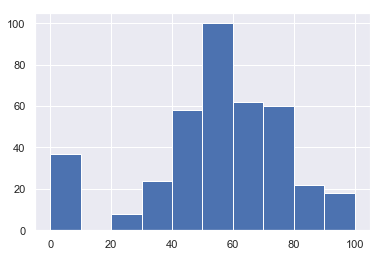

In [1155]:
df.score.hist()

Распределение похоже на нормальное, картину сиильно портит большое количество нулевых значений. 
Нужно понять, оставлять их или нет.

In [1156]:
# сколько нулевых значений
print('Учеников с нулевой оценкой - {:.2%}'
      .format(len(df[df.score == 0].index)/len(df.index)))

Учеников с нулевой оценкой - 9.51%


25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


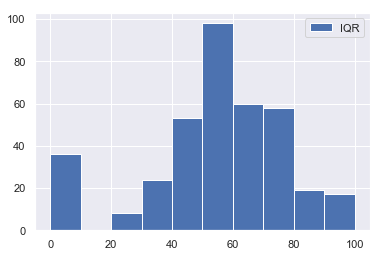

In [1157]:
median = stud.score.median()
IQR = stud.score.quantile(0.75) - stud.score.quantile(0.25)
perc25 = stud.score.quantile(0.25)
perc75 = stud.score.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

stud_score_plot = stud.score[stud.score.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
stud_score_plot.hist(bins = 10,label = 'IQR')
plt.legend();

Получаем, что ученики с нулевой оценкой значимы для нас, их выбрасывать пока нельзя. Мы вернёмся к анализу целевого показателя позже. Границы выбросов выходят за 100-бальную оценку.

## studytime_granular

В датасете есть 1 столбец, который отсутствует в описании - "studytime, granular", и его название очень схоже со столбцом "studytime". Давайте проанализируем их.

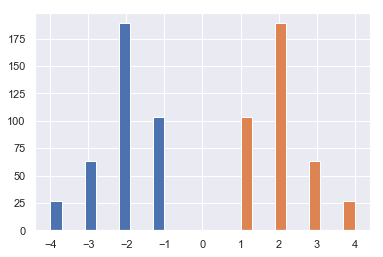

In [1158]:
(df['studytime_granular']*(1/3)).hist()
df['studytime'].hist()
plt.show()

In [1159]:
(df['studytime_granular']*(-1/3)).value_counts(dropna = False)

2.0    189
1.0    103
3.0     63
4.0     27
NaN      7
Name: studytime_granular, dtype: int64

In [1160]:
(df['studytime']).value_counts(dropna = False)

2.0    189
1.0    103
3.0     63
4.0     27
NaN      7
Name: studytime, dtype: int64

In [1161]:
df[['studytime_granular', 'studytime']].corr()

,studytime_granular,studytime
studytime_granular,1.0,-1.0
studytime,-1.0,1.0


Данные столбцы явно линейно зависимы, удалим столбец 'studytime, granular' ('studytime_gr'), т.к. он отсутствует в описании, а при необходимости легко восстановим.

In [1162]:
df.drop(['studytime_granular'], axis = 'columns', inplace = True)

In [1163]:
df.shape

(389, 30)

In [1165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
school          389 non-null object
sex             389 non-null object
age             389 non-null int64
address         374 non-null object
famsize         362 non-null object
p_status        344 non-null object
m_edu           386 non-null float64
f_edu           365 non-null float64
m_job           370 non-null object
f_job           353 non-null object
reason          372 non-null object
guardian        358 non-null object
traveltime      361 non-null float64
studytime       382 non-null float64
failures        367 non-null float64
schoolsup       380 non-null object
famsup          351 non-null object
paid            350 non-null object
activities      375 non-null object
nursery         374 non-null object
higher          369 non-null object
internet        355 non-null object
romantic        358 non-null object
famrel          362 non-null float64
freetime        380 non-nu

In [1164]:
len(df.dropna(axis = 0, how = 'any'))

97

# Промежуточное резюме

* удалили столбец 'studytime, granular', т.к. эти данные дублируют данные 'studytime' (с коэф. -1/3)
* общее количесвто пропусков невелико (менее 10%), но их распределение по данным не позволяет избавиться от пропусков простым удалением строк или столбцов

**В датасете осталось**

* 389 строк, из которых 97 без пропусков.
* 30 параметров (столбцов), 3 из которых не содержат пропусков (age, school, sex)
* Параметры можно разделить на группы
* количественные (3 шт.): age, absences, score
* номинативные (27 шт.), в т.ч.
    * бинарные (14 шт.): sex, address, famsize, p_status, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, school, counter
    * ранговые (13 шт.): m_edu, f_edu, m_job, f_job, reason, guardian, traveltime, studytime, failures, famrel, freetime, goout, health

## absences

Количество пропущенных занятий, числовая колонка

In [ ]:
# Смотрим на значения
median = dfents.absences.median()
IQR = dfents.absences.quantile(0.75) - dfents.absences.quantile(0.25)
perc25 = dfents.absences.quantile(0.25)
perc75 = dfents.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


dfents_absences_plot = dfents.absences[dfents.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
dfents_absences_plot.hist(bins = 10,label = 'IQR')
plt.legend();

In [ ]:
# Интересующая колонка
column = 'absences'
# Вывод состава колонки
compos = display_num(df, column)

In [ ]:
# посмотрим на предполагаемые выбросы в колонке absences
# рассмотрим данные больше 0.75-квантиля

df_absentee = df[df.absences > perc75]
df_absentee.sort_values('absences')

In [ ]:
# как распределены оценки в зависимости от прогулов у "прогульщиков"
f, ax = plt.subplots(figsize=(12,8))
ax.scatter(df_absentee.absences, df_absentee.score, s=200)
ax.plot(grid=True)
ax.grid(color = 'grey',    
        linewidth = 0.5,    
        linestyle = '-')
ax.set_facecolor('xkcd:white')
plt.show()

Видно, что данные распределены достаточно плотно до уровня 40 прогулов.

Посмотрим, сколько процентов датасета придется удалить, если считать выбросами значения, больше $perc75 + 1.5*IQR$

In [ ]:
df_absentee = df[df.absences > perc75 + 1.5*IQR]

print('Учеников с большим количеством прогулов - {:.2%}'
      .format(len(df_absentee.index)/len(df.index)))

Как видно, если отсекать выбросы, используя расчеты с интерквантильным расстоянием, то выбросим более 4 процентов датасета.

Предлагаю отсекать выбросы значением $absences = 40.0$, потому что данные до этого значения расположены достаточно плотно, 
а также это позволит сохранить максимум информации из этого маленького датасета.

In [ ]:
df_absentee = df[df.absences > 40.0]

print('Учеников с большим количеством прогулов - {:.2%}'
      .format(len(df_absentee.index)/len(df.index)))

In [ ]:
# удаляем выбросы в признаке absences
df = df[df.absences <= 40.0]

In [ ]:
# проверяем размеры датасета после удаления
df.shape

In [ ]:
# Теперь заполним пустые строки медианным значением.
df.absences = df.absences.fillna(df.absences.median())

# проверим количество пустых строк
df.absences.isna().sum()

### School

In [ ]:
# смотрим на значения
# Интересующая колонка
column = 'school'
# Вывод состава колонки
compos = display_cat(df, column)

Пропуски в данном столбце отсутствуют. Около 88% студентов выборки (общим размером 395 человек) обучаются в школе "GP". 

### Sex

In [ ]:
# смотрим на значения
# Интересующая колонка
column = 'sex'
# Вывод состава колонки
compos = display_cat(df, column)

В данном столбце пропусков нет. Имеется небольшой перевес, порядка 5% в пользу количества девочек в выборке.

### Age

Возраст ученика (от 15 до 22)

In [ ]:
# Интересующая колонка
column = 'age'
# Вывод состава колонки
compos = display_num(df, column)

In [ ]:
# Оценим количество учеников от 19 лет и старше

df[df[column] > 18][column].value_counts()

In [ ]:
# Положим значение 20 лет для студентов в возрасте 20 лет и старше, чем устраним выброс в 22 года и исключим одиночное 
# значение - 21 год.

df['age'].replace([21,22], 20, inplace=True)

In [ ]:
df['age'].value_counts()

В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. 
Устранён один выброс - 22 года. Введён возраст "20", вбирающий в себя от 20 лет

### school

In [ ]:
# Интересующая колонка
column = 'school'
# Вывод состава колонки
compos = display_cat(df, column)

Пропуски в данном столбце отсутствуют. Около 88% студентов выборки (общим размером 395 человек) обучаются в школе "GP".

### sex

Пол ученика: 'F' - женский, 'M' - мужской

In [ ]:
# Интересующая колонка
column = 'sex'
# Вывод состава колонки
compos = display_cat(df, column)

В данном столбце пропусков нет. Имеется небольшой перевес, порядка 5% в пользу количества девочек в выборке.

### Address

Тип адреса ученика: 'U' - городской, 'R' - за городом.

In [ ]:
# Интересующая колонка
column = 'address'
# Вывод состава колонки
compos = display_cat(df, column)

In [ ]:
display(df.groupby(['address', 'school']).traveltime.mean())

видно, что школа MS находится дальше школы GP. В среднем живущие в городе тратят на дорогу меньше времени. 
Можно заполнить пропущенные данные исходя из значения traveltime. Например, если traveltime <= 2, то address = U (городской), 
если > 2, то address = R (за городом). В тех случаях, где значение traveltime отсутсвует, можно установить наиболее часто 
встречающееся значение U. Или заполнить по определенной логике пропуски для признака traveltime, а потом дозаполнить address, 
по логике описанной выше. Либо удалить пустые.

In [ ]:
address_values = ['U', 'R']
def fill_address(df, address, traveltime):
    """
    Fill Nan values for column address
    :param df:
    :param address:
    :param traveltime:
    :return:
    """
    return_value = None
    if address not in address_values:
        traveltime_num = float(traveltime)
        if traveltime_num <= 2:
            return_value = 'U'
        elif traveltime_num > 2:
            return_value = 'R'
        else:
            return_value = df['address'].mode()[0]
    else:
        return_value = address
    return return_value

In [ ]:
df['address'] = df.apply(lambda x: fill_address(df, x['address'], x['traveltime']), axis=1)

In [ ]:
# Интересующая колонка
column = 'address'
# Вывод состава колонки
compos = display_cat(df, column)

Пропусков больше нет. Около 78% учеников живёт в городе.

### famsize

In [ ]:
# Интересующая колонка
column = 'famsize'
# Вывод состава колонки
compos = display_cat(df, column)

In [ ]:
# Посмотрим как влияет размер семьи на целевую переменную score у мальчиков и девочек
sns.boxplot(x='famsize', y='score', data=df, hue='sex')

In [ ]:
fs_df = df.pivot_table(values='counter', index=[
                       'famsize'], columns='p_status', aggfunc='count', fill_value=0)
display(fs_df)

In [ ]:
# Пропуски будут заполнены по следующей логике: если родители живут вместе, то famsize = GT3, если раздельно, то famsize = LE3, 
# а если значение Pstatus NaN, то самым часто встречающимся значением
famsize_values = ["GT3", "LE3"]
df['famsize'] = df.apply(lambda x: fill_famsize(df, x['famsize'], x['p_status']), axis=1)

In [ ]:
# Интересующая колонка
column = 'famsize'
# Вывод состава колонки
compos = display_cat(df, column)

Пропусков больше нет. Около 70% учеников живёт в семье с размером семьи больше 3х человек.

### p_status

Cтатус совместного жилья родителей: 'T' - живут вместе, 'A' - раздельно.

In [ ]:
# Интересующая колонка
column = 'p_status'
# Вывод состава колонки
compos = display_cat(df, column)

Признак имеет 42 пропуска. Заполнить их можно почти по такой же логике как и famsize. 
Если семья больше 3-х человек, то p_status = T, если 3 и меньше, то p_status = A

In [ ]:
p_status_val = ['A', 'T']

df['p_status'] = df.apply(lambda x: fill_p_status(x), axis=1)

In [ ]:
# Интересующая колонка
column = 'p_status'
# Вывод состава колонки
compos = display_cat(df, column)

Пропусков больше нет. Около 90% учеников живёт в семье с родителями, живущими вместе.

### m_edu

Образование матери: 0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее.

Преобразовано ниже в: 0 - 4 класса и меньше, 1 - 5-9 классы, 2 - среднее специальное или 11 классов, 3 - высшее.

In [ ]:
# Интересующая колонка
column = 'm_edu'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

In [ ]:
# Заполним в соответствии с вышеобозначенными категориями
def refilling_col(row):
    if pd.isna(row):
        return row
    elif row == 0:
        return 1
    else:
        return row - 1

df[column] = df[column].apply(refilling_col) 

In [ ]:
# Вывод состава колонки
compos = display_cat(df, column)

In [ ]:
#Так как пропущенных значений всего 3, заполним пропуски вручную.
df[df[column].isna()]

In [ ]:
# На основе анализа колонки 'm_job' было принято решения заполнить пропуски следующим образом:
def fillna_m_edu(row):
    if pd.isna(row['m_edu']):
        if row['m_job'] == 'other':
            return 2
        else:
            return 3
    return row['m_edu']


df[column] = df.apply(fillna_m_edu, axis=1)

In [ ]:
# После заполнения Nan превратим колонку в int
df[column] = df[column].astype(int)

# Вывод состава колонки
compos = display_cat(df, column)

3 пропущенных значений колонки были заполнены вручную на основе данных колонки "m_job". 
Наибольшее количество матерей с высшим образованием

### f_edu

Образование отца: 0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее

Преобразовано ниже в: 0 - 4 класса и меньше, 1 - 5-9 классы, 2 - среднее специальное или 11 классов, 3 - высшее.

In [ ]:
# Интересующая колонка
column = 'f_edu'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Имеется значение несоответствующее заявленным категориям. Логично предположить, что это значение "4" с опечаткой, исправим его.

In [ ]:
df['f_edu'] = df['f_edu'].replace(40, 4)

# Вывод состава колонки
compos = display_cat(df, column, plot=False)

In [ ]:
# Перезаполнение категорий, аналогично "m_edu"
def refilling_col(row):
    if pd.isna(row):
        return row
    elif row == 0:
        return 1
    else:
        return row - 1
df[column] = df[column].apply(refilling_col)

In [ ]:
# Вывод состава колонки
compos = display_cat(df, column)

In [ ]:
df[df[column].isna()]

Пропуски можно заполнить самым часто встречающимся значением, либо медианой, хотя в данном случае это может быть неверным подходом. Можно использовать следующий подход. Количество мужчин и женщин с образованием 2 и 3 почти равно, и во многих случаях образования обоих родителей совпадают. Хотя в некоторых строках образование матери чуть выше образования отца. Поэтому заполним этот признак так: если профессия отца == teacher, то 4, т.к. ниже при анализе признака Fjob видно, что почти все те кто работает учителем, имеют образование 4, иначе если образование матери = 4, то образование отца = 3, а в остальных слуаях оно будет таким же как и у матери

In [ ]:
f_edu_val = [0.0, 1.0, 2.0, 3.0]

In [ ]:
df['f_edu'] = df.apply(lambda x: fill_f_edu(x), axis=1)

In [ ]:
# Вывод состава колонки
compos = display_cat(df, column)

24 пропущенных значений колонки были заполнены на основе данных колонок "f_job" и 'm_edu'.
Наибольшее количество отцов с образованием 5-9 классы.

В целом видно, что мамы чуть более образованнее, чем папы. Проанализируем влияние образования родителей на целевую переменную score. Создадим новый признак = среднее от двух значений Medu и Fedu (среднее от образования обоих родителей)

In [ ]:
df['edu_avg'] = df.apply(lambda x: x[['m_edu', 'f_edu']].mean(), axis=1)

In [ ]:
sns.boxplot(x='edu_avg', y='score', data=df)

Чем образованее родители, тем лучше результаты учеников

In [ ]:
sns.boxplot(x='edu_avg', y='score', data=df, hue='sex')

Влияние образования родителей на результат экзамена, прослеживается и у мальчиков и у девочек

### m_job

Работа матери: 'teacher' - учитель, 'health' - сфера здравоохранения, services' - гос служба, 'at_home' - не работает, 'other' - другое.

In [ ]:
# Интересующая колонка
column = 'm_job'
# Вывод состава колонки
compos = display_cat(df, column)

In [ ]:
df[df[column].isna()]

Есть предположение, что есть связь между образованием и работой. Исходя из этой информации можно будет заполнить пропуски.

In [ ]:
df.groupby(['m_edu'])['m_job'].value_counts()

In [ ]:
mode_change(df, 'm_job', 'm_edu')

In [ ]:
df[df[column].isna()]

Пропуски убраны. Наибольшее количество матерей работает (помимо варианта "другое") на гос. службе.

### f_job

Работа отца: 'teacher' - учитель, 'health' - сфера здравоохранения, services' - гос служба, 'at_home' - не работает, 'other' - другое.

Количество None-пропусков: 36
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 9.3%

Состав колонки f_job


,total,proportion
other,194,0.549575
services,99,0.280453
teacher,29,0.082153
at_home,16,0.045326
health,15,0.042493


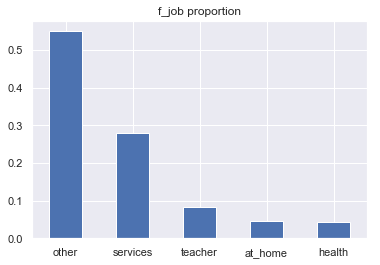

In [1050]:
# Интересующая колонка
column = 'f_job'
# Вывод состава колонки
compos = display_cat(df, column)

In [1051]:
df[df[column].isna()]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,1
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0,1
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,-6.0,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0,1
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0,1
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0,1
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0,1
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0,1
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0,1
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0,1
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0,1


Есть предположение, что есть связь между образованием и работой. Исходя из этой информации можно будет заполнить пропуски.

In [1052]:
df.groupby(['f_edu'])['f_job'].value_counts()

f_edu  f_job   
0.0    other        2
1.0    other       46
       services    18
       at_home      3
       health       1
2.0    other       58
       services    26
       at_home      6
       health       1
3.0    other       50
       services    30
       at_home      3
       health       3
       teacher      1
4.0    other       30
       teacher     25
       services    17
       health       8
       at_home      2
40.0   other        1
Name: f_job, dtype: int64

In [1053]:
mode_change(df, 'f_job', 'f_edu')

3 nan  ->  other
17 nan  ->  other
22 nan  ->  other
26 nan  ->  other
31 nan  ->  other
44 nan  ->  other
47 nan  ->  other
52 nan  ->  other
59 nan  ->  other
68 nan  ->  other
107 nan  ->  other
118 nan  ->  other
120 nan  ->  other
135 nan  ->  other
151 nan  ->  other
152 nan  ->  other
160 nan  ->  other
169 nan  ->  other
182 nan  ->  other
216 nan  ->  other
229 nan  ->  other
250 nan  ->  other
266 nan  ->  other
294 nan  ->  other
303 nan  ->  other
309 nan  ->  other
316 nan  ->  other
336 nan  ->  other
341 nan  ->  other
345 nan  ->  other
363 nan  ->  other
365 nan  ->  other
373 nan  ->  other
384 nan  ->  other
161 nan  ->  other
374 nan  ->  other


In [1054]:
df[df[column].isna()]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter


Пропуски убраны. Наибольшее количество отцов также работает (помимо варианта "другое") на гос. службе.

## reason

Причина выбора школы: 'home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое.

Количество None-пропусков: 17
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 4.4%

Состав колонки reason


,total,proportion
course,135,0.362903
reputation,102,0.274194
home,101,0.271505
other,34,0.091398


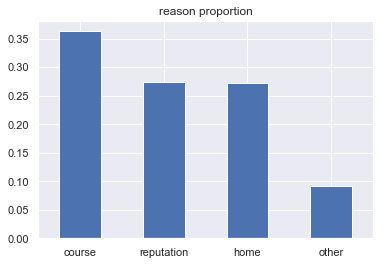

In [1055]:
# Интересующая колонка
column = 'reason'
# Вывод состава колонки
compos = display_cat(df, column)

Здесь 17 пропусков. Можно этот признак заполнить значением home (близость к дому), если время в пути до школы(traveltime) 1.

In [1056]:
df['reason'] = df.apply(lambda x: 'home' if x['traveltime'] == 1.0 else x['reason'], axis=1)

In [1057]:
df[df[column].isna()]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0,1
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0,1
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0,1
382,MS,M,17,U,GT3,T,2.0,3.0,other,services,NaN,father,2.0,2.0,0.0,no,no,no,yes,yes,-6.0,NaN,yes,no,4.0,4.0,3.0,3.0,2.0,50.0,1


Осталось 4 пропуска, которые предлагаю заменить на Other

In [1058]:
df['reason'].fillna('other', inplace=True)

Пропуски убраны. Наибольшее количество причин выбора школы связаны с образовательной программой.

## guardian

Опекун: 'mother' - мать, 'father' - отец, 'other' - другое. По всей видимости здесь имеется в виду, кто из родителей (или не из родителей в случае "other") является наиболее сильно заботящимся о ребёнке

Количество None-пропусков: 31
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 8.0%

Состав колонки guardian


,total,proportion
mother,248,0.692737
father,86,0.240223
other,24,0.067039


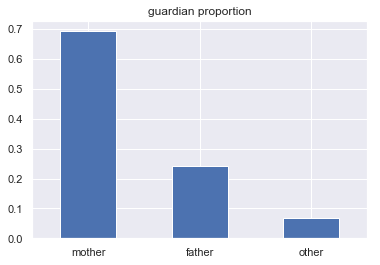

In [1059]:
# Интересующая колонка
column = 'guardian'
# Вывод состава колонки
compos = display_cat(df, column)

Попробуем объединить родителей в одну колонку

In [1060]:
df[column] = df[column].apply(lambda x: 'parent' if (x in ['mother', 'father']) else x)

Заменим пропуски на группу other

In [1061]:
df['guardian'].fillna('other', inplace=True)

Пропуски убраны. Наибольшее количество опекунов - матери.
Вместо "mother"-"father": "parent". Размер выборки "other" в районе 30.

## traveltime

Время в пути до школы: 1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.

Преобразовано ниже в: 0 - <15 мин., 1 - 15-30 мин., 2 - больше 30 мин.

In [1062]:
# Интересующая колонка
column = 'traveltime'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 28
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 7.2%

Состав колонки traveltime


,total,proportion
1.0,239,0.662050
2.0,94,0.260388
3.0,21,0.058172
4.0,7,0.019391


Пропусков 28. Можно поступить от обратного как с признаком address. Если учащийся живёт в городе, то установить значение 2, если за городом, то 4. также можно еще смотреть на признак reason, если он равен home, то для городских установить значение 1, а для тех кто за городом 3

In [1063]:
traveltime_values = [1.0, 2.0, 3.0, 4.0]

In [1064]:
df['traveltime'] = df.apply(lambda x: fill_traveltime(x), axis=1)

In [1065]:
# Перезаполнение категорий
def refilling_col_up(row):
    if pd.isna(row):
        return row
    elif (row == 4) or (row == 3):
        return 2
    else:
        return row - 1
df[column] = df[column].apply(refilling_col_up)

In [1066]:
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 3
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 0.8%

Состав колонки traveltime


,total,proportion
0.0,243,0.629534
1.0,108,0.279793
2.0,35,0.090674


Пропуски убраны. В 65% случаев ученики тратят на дорогу меньше 15 минут.

## studytime

Время на учёбу помимо школы в неделю: 1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов.

Преобразовано ниже в 0 - <2 часов, 1 - 2-5 часов, 2 - 5-10 часов и больше.

In [1067]:
# Интересующая колонка
column = 'studytime'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 7
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.8%

Состав колонки studytime


,total,proportion
2.0,189,0.494764
1.0,103,0.269634
3.0,63,0.164921
4.0,27,0.070681


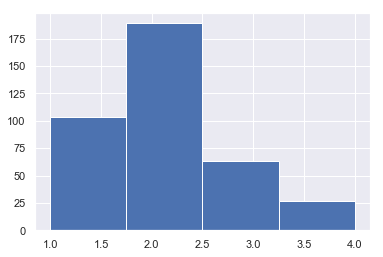

In [1068]:
df.studytime.hist(bins = 4)
plt.show()

Распределение похоже на нормальное с центром в значении "2", то есть большинство тратит время на учебу помимо школы от 2 до 5 часов в неделю с отколонениями в меньшую и большую стороны. Заполним пропуски модой.

In [1069]:
mode_change(df, 'studytime', 'studytime')

17 nan  ->  2.0
91 nan  ->  2.0
112 nan  ->  2.0
129 nan  ->  2.0
227 nan  ->  2.0
266 nan  ->  2.0
314 nan  ->  2.0


In [1070]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    if row == 4:
        return 2
    else:
        return row - 1
df[column] = df[column].apply(refilling_col)

## failures

Количество внеучебных неудач: n, если 1<=n<=3, иначе 0 (вынужденное исправление, так как значения 4 в датасете нет, а есть неописанный 0.).

Преобразуем ниже в число неудач от 0 до 2

Ввиду отсутствия дополнительных разъяснений по поводу данной колонки, в частности, что такое 'внеучебная неудача', предположим:

Значение в этой колонке соответствует числу проваленных госэкзаменов ("внеучебных" в значении "не по математике")
0 - отсутствие неудач, то есть остальные предметы были написаны удачно (однако стоит иметь в виду, что здесь могут иметь место и скрытые пропуски)

In [1071]:
# Интересующая колонка
column = 'failures'
# Вывод состава колонки
compos = display_cat(df, column,plot=False)

Количество None-пропусков: 22
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 5.7%

Состав колонки failures


,total,proportion
0.0,290,0.790191
1.0,48,0.130790
2.0,15,0.040872
3.0,14,0.038147


In [1072]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row   
    elif (row == 3) or (row == 2):
        return 2
    else:
        return row
df[column] = df[column].apply(refilling_col)

"0" - самое частое значение и вероятнее всего пропуски в данном случае - "скрытый 0". Зaполним пропуски модой.

In [1073]:
df['failures'].fillna(0, inplace=True)

Пропуски убраны. Чаще всего ученики выделяют внешкольного времени на учёбу от 2 до 5 часов в неделю.

## schoolsup

Дополнительная образовательная поддержка: yes или no

Количество None-пропусков: 9
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.3%

Состав колонки schoolsup


,total,proportion
no,331,0.871053
yes,49,0.128947


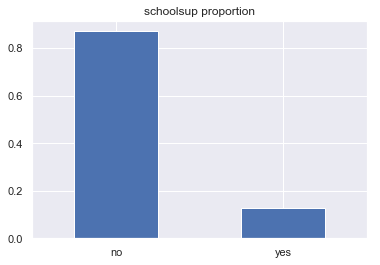

In [1074]:
# Интересующая колонка
column = 'schoolsup'
# Вывод состава колонки
compos = display_cat(df, column)

Есть 9 пропусков. Можно заменить их на самое часто встречающееся значение no. Большинство учащихся не имели дополнительной образовательной поддержки

In [1075]:
df['schoolsup'].fillna('no', inplace=True)

Пропуски убраны. В большинстве случаев образовательная поддержка не оказывается.

## famsup

Семейная образовательная поддержка: yes или no

Количество None-пропусков: 38
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 9.8%

Состав колонки famsup


,total,proportion
yes,216,0.615385
no,135,0.384615


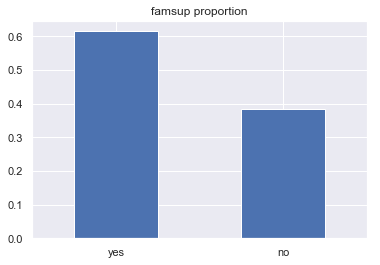

In [1076]:
# Интересующая колонка
column = 'famsup'
# Вывод состава колонки
compos = display_cat(df, column)

In [1077]:
get_stat_dif(df, 'score', 'famsup')

Cтатистически значимые различия для колонки famsup не найдены (0.1)


Здравый смысл подсказывает, что, наверное, семейная образовательная поддержка может влиять на оценку на госэкзамене как результат образования. Но в данном случае, столбец можно удалить.

## paid

Дополнительные платные занятия по математике: yes или no.

Количество None-пропусков: 39
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 10.0%

Состав колонки paid


,total,proportion
no,197,0.562857
yes,153,0.437143


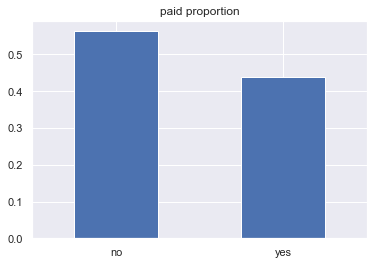

In [1078]:
# Интересующая колонка
column = 'paid'
# Вывод состава колонки
compos = display_cat(df, column)

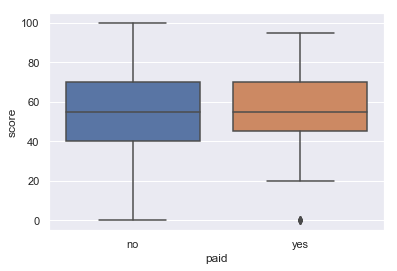

In [1079]:
sns.boxplot(x='paid', y='score', data=df)

Признак особого влияния на значение score не имеет. Хотя, здравый смысл говорит об обратном, образовательная поддержка в семье должна влиять на оценку на госэкзамене.

## activities

Дополнительные внеучебные занятия: yes или no

Количество None-пропусков: 14
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.6%

Состав колонки activities


,total,proportion
yes,192,0.512
no,183,0.488


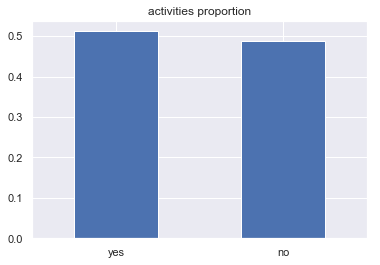

In [1080]:
# Интересующая колонка
column = 'activities'
# Вывод состава колонки
compos = display_cat(df, column)

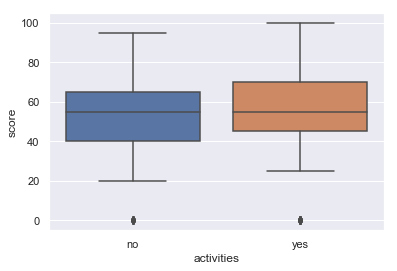

In [1081]:
sns.boxplot(x='activities', y='score', data=df)

Занимающиеся дополнительно, показали результаты на экзамене чуть лучше.

На основе колонки "reason" сделаем заполнение пустых значений.

In [1082]:
mode_change(df, 'activities', 'reason')

43 nan  ->  no
44 nan  ->  no
54 nan  ->  no
81 nan  ->  no
99 nan  ->  no
116 nan  ->  yes
126 nan  ->  no
140 nan  ->  yes
141 nan  ->  yes
160 nan  ->  no
163 nan  ->  no
207 nan  ->  no
212 nan  ->  no
393 nan  ->  no


Пропуски убраны. Примерно равное количество студентов, имеющих внеучебные занятия и не имеющих.

## nursery

Посещал детский сад: yes или no

Количество None-пропусков: 15
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.9%

Состав колонки nursery


,total,proportion
yes,297,0.794118
no,77,0.205882


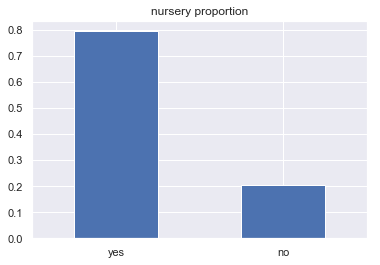

In [1083]:
# Интересующая колонка
column = 'nursery'
# Вывод состава колонки
compos = display_cat(df, column)

Признак имеет 16 пропусков. Можно заполнить их самым часто встречающимся значением yes. Большинство учащихся посещали детский сад

In [1084]:
df['nursery'].fillna('yes', inplace=True)

Пропуски убраны. Большинство учеников посещало детский сад.

## higher

Количество None-пропусков: 20
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 5.1%

Состав колонки higher


,total,proportion
yes,350,0.948509
no,19,0.051491


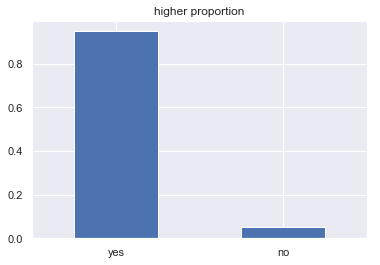

In [1085]:
# Интересующая колонка
column = 'higher'
# Вывод состава колонки
compos = display_cat(df, column)

признак имеет 7 пропусков. В основном почти все учащиеся хотят получить высшее образование, заполним пропуски

In [1086]:
df['higher'].fillna('yes', inplace=True)

Пропуски убраны. Только 5 % учеников не хотели бы иметь высшее образование. Данная колонка не рекомендуется для выявления рисков, так как размер выборки со значением "no" - 20, что меньше 30.

## internet

Наличие интернета дома: yes или no

Количество None-пропусков: 34
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 8.7%

Состав колонки internet


,total,proportion
yes,300,0.84507
no,55,0.15493


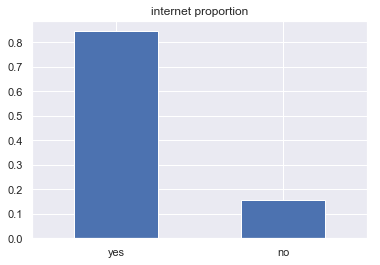

In [1087]:
# Интересующая колонка
column = 'internet'
# Вывод состава колонки
compos = display_cat_compos(df, column)

В данном признаке есть много просуков 34. У большей части детей есть дома интернет, заполним пропуски.

In [1088]:
df['internet'].fillna('yes', inplace=True)

Пропуски убраны. У большинства учеников есть интернет.

## romantic

Количество None-пропусков: 31
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 8.0%

Состав колонки romantic


,total,proportion
no,235,0.656425
yes,123,0.343575


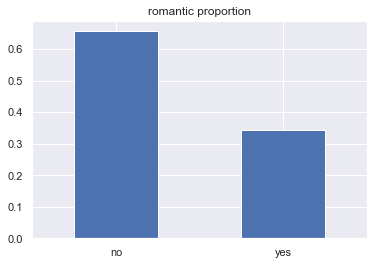

In [1089]:
# Интересующая колонка
column = 'romantic'
# Вывод состава колонки
compos = display_cat_compos(df, column)

В этом признаке есть 31 пропуск. Треть учащихся состоят в романтических отношениях

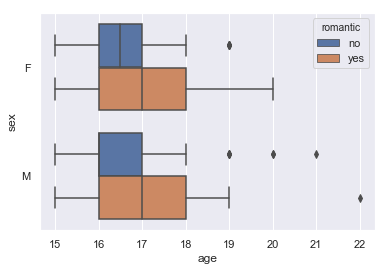

In [1090]:
sns.boxplot(x='age', y='sex', data=df, hue='romantic')

создадим новый числовой признак, который будет содержать значения 0 и 1. 0 не состоит в романтических отношениях, 1 - состоит

In [1091]:
def change_value(value):
    
    if pd.isnull(value):
        return value
    if value == 'yes':
        return 1
    if value == 'no':
        return 0

In [1092]:
df['romantic_num'] = df['romantic'].apply(change_value)                                             

посмотрим на количество девочек и мальчиков состоящих в романтических отношениях в разном возрасте

In [1093]:
pt = pd.pivot_table(df, columns=['age'], index=['sex'], values='romantic_num', aggfunc={'romantic_num':sum}, fill_value=0)
pt

age,15,16,17,18,19,20,21,22
sex,,,,,,,,
F,10,15,24,20,7,1,0,0
M,8,12,10,12,3,0,0,1


Видно, что девочки более романтичные особы. Поменяем пропуски в зависимости от значений столбца 'sex'

In [1094]:
romantic_values = ["no", "yes"]

In [1095]:
def fill_romantic(row):
    """
    Заполнение NaN для столбца romantic
    """
    return_value = None
    if row ['romantic'] not in romantic_values:
        if row['sex'] == 'F':
            return_value = 'yes'
        elif row['sex'] == 'M':
            return_value = 'no'
        else:
            return_value = row ['romantic']
    else:
        return_value = row ['romantic']
    return return_value

In [1096]:
df['romantic'] = df.apply(lambda x: fill_romantic(x), axis=1)

Пропуски убраны. Большинство студентов не находится в романтических отношениях (или скрывают их - скрытые пропуски)

## famrel

Cемейные отношения: от 1 - очень плохо до 5 - очень хорошо

Преобразовано в: от 0 - плохо до 2 - очень хорошо

In [1097]:
# Интересующая колонка
column = 'famrel'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.9%

Состав колонки famrel


,total,proportion
4.0,178,0.491713
5.0,97,0.267956
3.0,62,0.171271
2.0,17,0.046961
1.0,7,0.019337
-1.0,1,0.002762


Видим, что имеет место значение "-1", не соответствующее диапазону (1..5). Оно может как соответствовать "1", то есть написано с опечаткой, так и обозначать пропуск. Рассмотрим его и сравним с значениями "1-2".

In [1098]:
display(df[df[column] == -1])
display(df[df[column].isin([1,2])].sort_values([column]).head(10))

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter,romantic_num
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,parent,0.0,0.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0,1,0.0


,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter,romantic_num
184,GP,F,16,U,GT3,T,3.0,2.0,other,other,home,parent,0.0,1.0,0.0,no,yes,NaN,no,yes,-6.0,yes,yes,no,1.0,2.0,2.0,1.0,14.0,60.0,1,0.0
357,MS,F,17,U,LE3,NaN,3.0,2.0,services,other,reputation,parent,1.0,1.0,0.0,no,no,no,no,yes,-6.0,yes,no,yes,1.0,2.0,3.0,5.0,2.0,55.0,1,1.0
299,GP,M,18,U,LE3,T,4.0,4.0,teacher,teacher,home,parent,0.0,0.0,0.0,no,yes,yes,no,yes,-3.0,yes,yes,yes,1.0,4.0,2.0,1.0,5.0,80.0,1,1.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,home,parent,0.0,2.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0,1,1.0
108,GP,M,15,R,GT3,NaN,4.0,4.0,other,other,home,parent,2.0,2.0,0.0,no,yes,yes,yes,yes,-12.0,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0,1,1.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,parent,1.0,1.0,1.0,no,no,no,yes,yes,-6.0,yes,yes,no,1.0,1.0,1.0,5.0,0.0,0.0,1,0.0
207,GP,F,16,U,GT3,T,4.0,3.0,teacher,other,home,parent,0.0,1.0,0.0,no,no,yes,no,yes,-6.0,yes,yes,yes,1.0,3.0,2.0,1.0,10.0,65.0,1,1.0
363,MS,F,17,U,LE3,T,4.0,4.0,at_home,other,home,parent,0.0,1.0,0.0,no,NaN,yes,yes,yes,-6.0,yes,yes,yes,2.0,3.0,4.0,1.0,0.0,75.0,1,1.0
296,GP,F,19,U,GT3,T,4.0,4.0,health,other,reputation,other,1.0,1.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,2.0,3.0,4.0,2.0,0.0,0.0,1,0.0
278,GP,F,18,U,GT3,T,4.0,4.0,health,health,home,parent,0.0,1.0,1.0,yes,yes,no,yes,yes,-6.0,yes,yes,yes,2.0,4.0,4.0,4.0,15.0,40.0,1,1.0


Ввиду отсутствия различий у "-1" с показателями в других столбцах у строк с значением "1", заполним его как "1"

In [1099]:
df[column].replace(-1,1, inplace=True)

# Вывод состава колонки
compos = display_cat_compos(df, column, plot=False)

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.9%

Состав колонки famrel


,total,proportion
4.0,178,0.491713
5.0,97,0.267956
3.0,62,0.171271
2.0,17,0.046961
1.0,8,0.022099


In [1100]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row in [1,2,3]):
        return 0
    else:
        return row - 3
df[column] = df[column].apply(refilling_col)

Пропуски замолним медианой

In [1101]:
median = df['famrel'].median()
df['famrel'] = df['famrel'].fillna(median)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки famrel


,total,proportion
1.0,205,0.526992
2.0,97,0.249357
0.0,87,0.223650


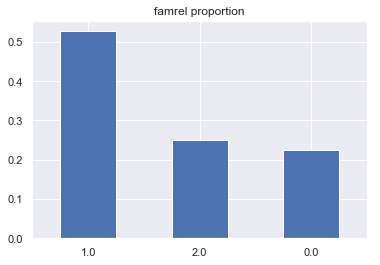

In [1102]:
# Вывод состава колонки
compos = display_cat(df, column)

Пропуски убраны. Чаще всего семейные отношения "хорошие"

## freetime

Свободное время после школы: от 1 - очень мало до 5 - очень много

Преобразовано ниже в: от 0 - мало до 3 - очень много

In [1103]:
# Интересующая колонка
column = 'freetime'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 9
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.3%

Состав колонки freetime


,total,proportion
3.0,152,0.400000
4.0,110,0.289474
2.0,63,0.165789
5.0,37,0.097368
1.0,18,0.047368


Распределение похоже на нормальное с центром в 3, то есть у большинства учеников есть свободное время с некоторыми отклонениями в ту (мало) и другую (много) стороны

Пропуски можно заменить на популярное значение 3:

In [1104]:
def set_val_if(df, col, val, fn):
    df[col] = df[col].apply(lambda x: val if fn(x) else x)

In [1105]:
set_val_if(df, 'freetime', 1, lambda x: pd.isna(x))

Преобразуем в: от 0 - мало до 3 - очень много

In [1106]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    else:
        return row - 2
df[column] = df[column].apply(refilling_col)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки freetime


,total,proportion
1.0,152,0.390746
2.0,110,0.282776
0.0,90,0.231362
3.0,37,0.095116


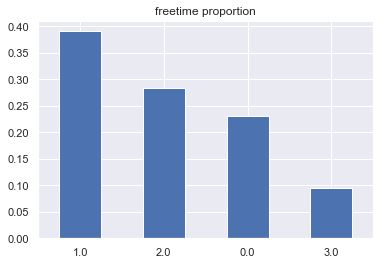

In [1107]:
# Вывод состава колонки
compos = display_cat_compos(df, column)

Пропуски убраны. В большинстве случаев у учеников имеется "не мало" свободного времени после школы

## goout

Проведение времени с друзьями: от 1 - очень мало до 5 - очень много

Преобразовано ниже: от 0 - мало до 3 - очень много

In [1108]:
# Интересующая колонка
column = 'goout'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 7
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.8%

Состав колонки goout


,total,proportion
3.0,126,0.329843
2.0,101,0.264398
4.0,81,0.212042
5.0,51,0.133508
1.0,23,0.060209


Распределение похоже на нормальное с центром в 3, то есть большинства учеников достаточно времени проводит с друзьями с некоторыми отклонениями в ту (мало) и другую (много) стороны

Пропуски можно заменить на популярное значение 3:

In [1109]:
set_val_if(df, 'goout', 3, lambda x: pd.isna(x))

In [1110]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    else:
        return row - 2
df[column] = df[column].apply(refilling_col)

Пропуски убраны. Время с друзьями ученики как правило проводят не много.

## health_level

Текущее состояние здоровья: от 1 - очень плохо до 5 - очень хорошо

Преобразовано ниже в: от 0 - плохо до 2 - хорошо

In [1111]:
# Интересующая колонка
column = 'health_level'
# Вывод состава колонки
compos = display_cat(df, column, plot=False)

Количество None-пропусков: 15
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.9%

Состав колонки health_level


,total,proportion
5.0,137,0.366310
3.0,88,0.235294
4.0,60,0.160428
1.0,47,0.125668
2.0,42,0.112299


Пропуски замолним медианой

In [1112]:
median = df['health_level'].median()
df['health_level'] = df['health_level'].fillna(median)

In [1113]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    elif (row == 3) or (row == 4):
        return 1    
    else:
        return 2
df[column] = df[column].apply(refilling_col)

Пропуски убраны. Большинство учеников имеют "хорошее здоровые".

## score

Баллы по госэкзамену по математике (целевой параметр)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки score


,score
count,389.000000
mean,52.262211
std,22.919022
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,100.000000



Выбросы не обнаружены


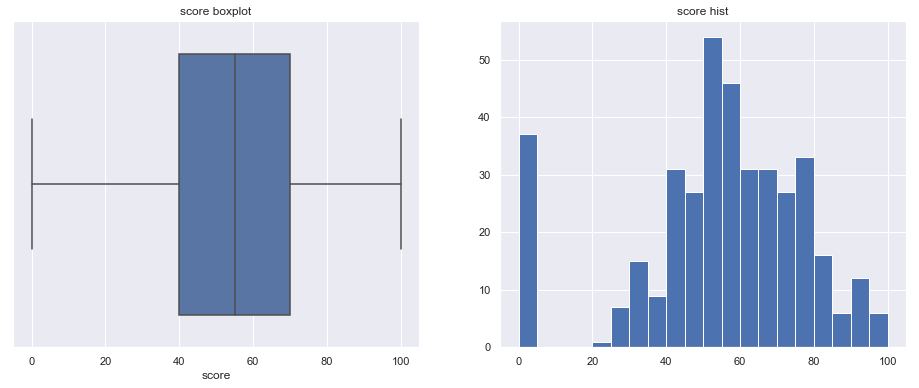

In [1114]:
# Интересующая колонка
column = 'score'
# Вывод состава колонки
compos = display_num(df, column, bin_koef=5)

Особенностью анализа последней колонки является то, что она - целевой параметр обучения модели, а 0 характеризует несдачу экзамена.

Оценим состав колонки без 0

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки score


,score
count,352.000000
mean,57.755682
std,16.200928
min,20.000000
25%,45.000000
50%,55.000000
75%,70.000000
max,100.000000



Выбросы не обнаружены


50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

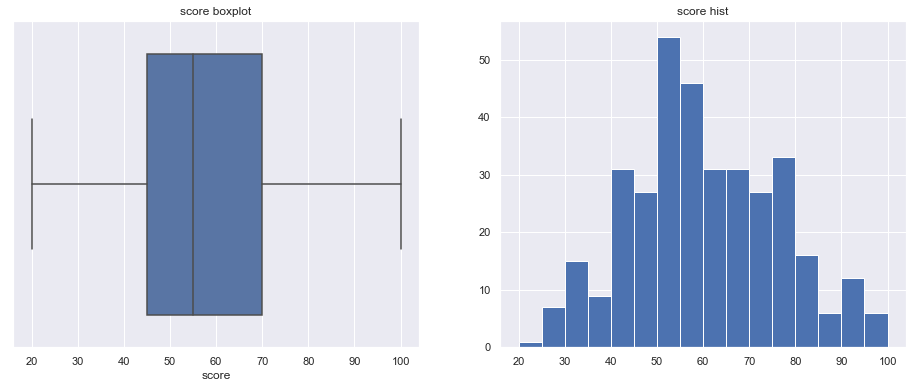

In [1115]:
# Вывод состава колонки
compos = display_num(df[df[column] > 0], column, bin_koef=5)
df[column].value_counts()

Баллы по математике представляют собой дискретный ряд с шагом в 5 баллов. При этом порог успешной сдачи - 20 баллов, поэтому значение "0", по всей видимости, соответствует проваленному экзамену с баллами в диапазоне от 0 до 15. При анализе всей совокупности данных показателя "score" значение "0" не является выбросом. Однако если первоначальное распределение было ненулевым (см. распределение без 0), то посчитанная нижняя граница выбросов оказывается больше 0, и тогда значение "0" можно было бы считать выбросом. Остановимся на первом варианте интерпретации значений.

Таким образом, 9% от числа непропущенных данных - провальные. Удалить эти сведения, или заменить на соответствующие диапазону в границах выбросов не представляется возможным, так как они имеют важную смысловую нагрузку.

Оценим теперь состав пропущенных значений в показателе "score" и решим, что с ними делать дальше.

In [1116]:
df[df[column].isna()]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter,romantic_num


In [1117]:
df[df[column] == 0].head(10)

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health_level,absences,score,counter,romantic_num
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,home,parent,0.0,0.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,0.0,1.0,1.0,1,0.0,0.0,1,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,parent,1.0,2.0,2.0,no,yes,no,no,yes,-9.0,yes,yes,yes,1.0,0.0,0.0,2,0.0,0.0,1,1.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,parent,2.0,0.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,1.0,0.0,1.0,1,0.0,0.0,1,1.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,parent,2.0,1.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,2.0,1.0,1.0,2,0.0,0.0,1,1.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,other,home,parent,0.0,2.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,1.0,1.0,1.0,2,0.0,0.0,1,1.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,parent,2.0,1.0,0.0,no,no,NaN,no,yes,-6.0,yes,no,no,1.0,2.0,3.0,2,0.0,0.0,1,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,other,other,1.0,0.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,1.0,1.0,0.0,2,0.0,0.0,1,1.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,other,parent,1.0,2.0,0.0,yes,yes,no,yes,yes,-12.0,yes,yes,no,0.0,0.0,0.0,1,0.0,0.0,1,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,other,0.0,0.0,2.0,no,yes,no,no,yes,-3.0,yes,yes,no,2.0,2.0,3.0,2,0.0,0.0,1,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,parent,0.0,1.0,2.0,no,NaN,no,no,yes,-6.0,yes,yes,no,0.0,1.0,0.0,1,0.0,0.0,1,0.0


Можно предположить, что эти нули - либо не за знания (а, например, за поведение, за неявку, за несоответствие оформления требованиям), либо это пропуски.

Поэтому я бы считал эти нули пропусками, потому что к оценкам за знания (цель госэкзамена), эти нули никакого отношения не имеют.

In [1118]:
set_val_if(df, 'score', None, lambda x: x == 0)

А все пропуски заменил бы медианой, чтобы не терять 11% датасета

In [1119]:
set_val_if(df, 'score', df.score.median(), lambda x: pd.isna(x))

Пропуски убраны.

# Итоговый анализ показателей

Проанализируем имеющиеся показатели с точки зрения влияния на целевой параметр "score"

## Корреляционный анализ

Корреляционный анализ проводится для истинно числовых переменных. К таковым однозначно относятся "age", "absences", "score".

Переменная "failures" по смыслу является числовой переменной (большее значение - больше пропусков), однако необходимо учесть, что она может принимать всего 3 значения (от 0 до 2), в связи с чем больший смысл имеется в её анализе как ранговой переменной.

In [1121]:
def plot_corr(df, cols, figsize=30, figscale=1.4, fmt='.2f'):
    sns.set(font_scale=figscale)
    plt.subplots(figsize=(figsize, figsize))
    sns.heatmap(df[cols].corr(), square=True, annot=True, fmt=fmt, linewidths=0.1, cmap="RdBu")

In [1122]:
# числовые
cat_flds = ['age', 'm_edu', 'f_edu', 'traveltime', 'studytime', 'failures', 'studytime', 'famrel', 'freetime', 'goout', 'health_level', 'absences', 'score']
# номинативные
num_flds = ['school', 'sex', 'address', 'famsize', 'p_status', 'm_job', 'f_job', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
# все
all_flds = ['school','sex','age', 'address','famsize','p_status', 'm_edu', 'f_edu', 'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health_level', 'absences']

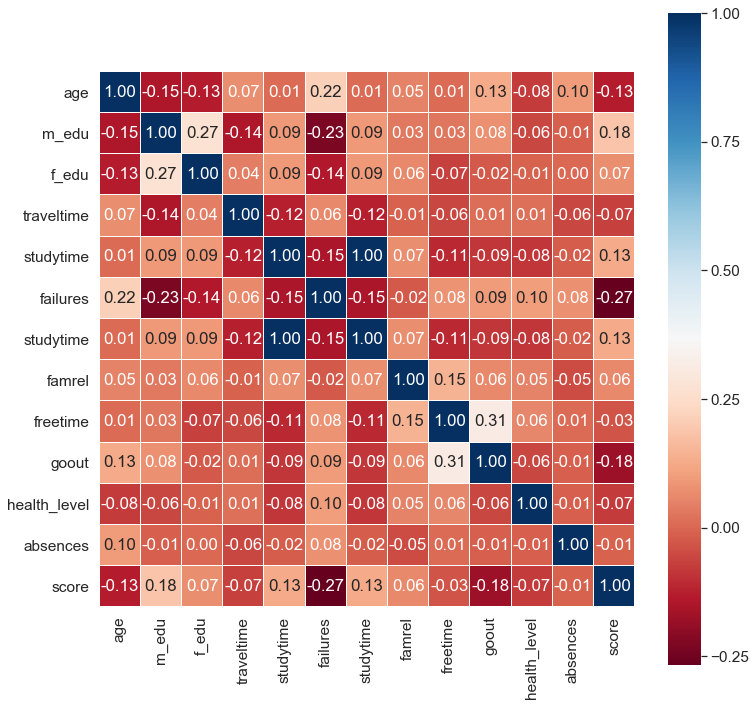

In [1123]:
plot_corr(df, cat_flds, figsize=12)

Значимых корелляций между количественными переменными, оставленными в рассмотрение, не видно.

In [1124]:
for col in all_flds:
    get_stat_dif(df, 'score', col)

Cтатистически значимые различия для колонки school не найдены (0.3)
Найдены статистически значимые различия для колонки sex (1.0)
Cтатистически значимые различия для колонки age не найдены (0.1)
Найдены статистически значимые различия для колонки address (4.8)
Cтатистически значимые различия для колонки famsize не найдены (0.1)
Cтатистически значимые различия для колонки p_status не найдены (0.1)
Найдены статистически значимые различия для колонки m_edu (21.3)
Найдены статистически значимые различия для колонки f_edu (1.1)
Найдены статистически значимые различия для колонки m_job (3.3)
Найдены статистически значимые различия для колонки f_job (1.9)
Cтатистически значимые различия для колонки reason не найдены (0.1)
Cтатистически значимые различия для колонки guardian не найдены (0.3)
Cтатистически значимые различия для колонки traveltime не найдены (0.1)
Найдены статистически значимые различия для колонки studytime (14.0)
Найдены статистически значимые различия для колонки failures (15

C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Найдены статистически значимые различия для колонки goout (2.6)
Найдены статистически значимые различия для колонки health_level (2.3)
Cтатистически значимые различия для колонки absences не найдены (0.1)


На основе результатов анализа составляем список столбцов, которые НЕ будут участвовать в дальнейшем.

In [1125]:
columns_for_delete = ['school', 'sex', 'age', 'famsize', 'p_status', 'f_job', 'reason', 'guardian', 'traveltime', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'absences']

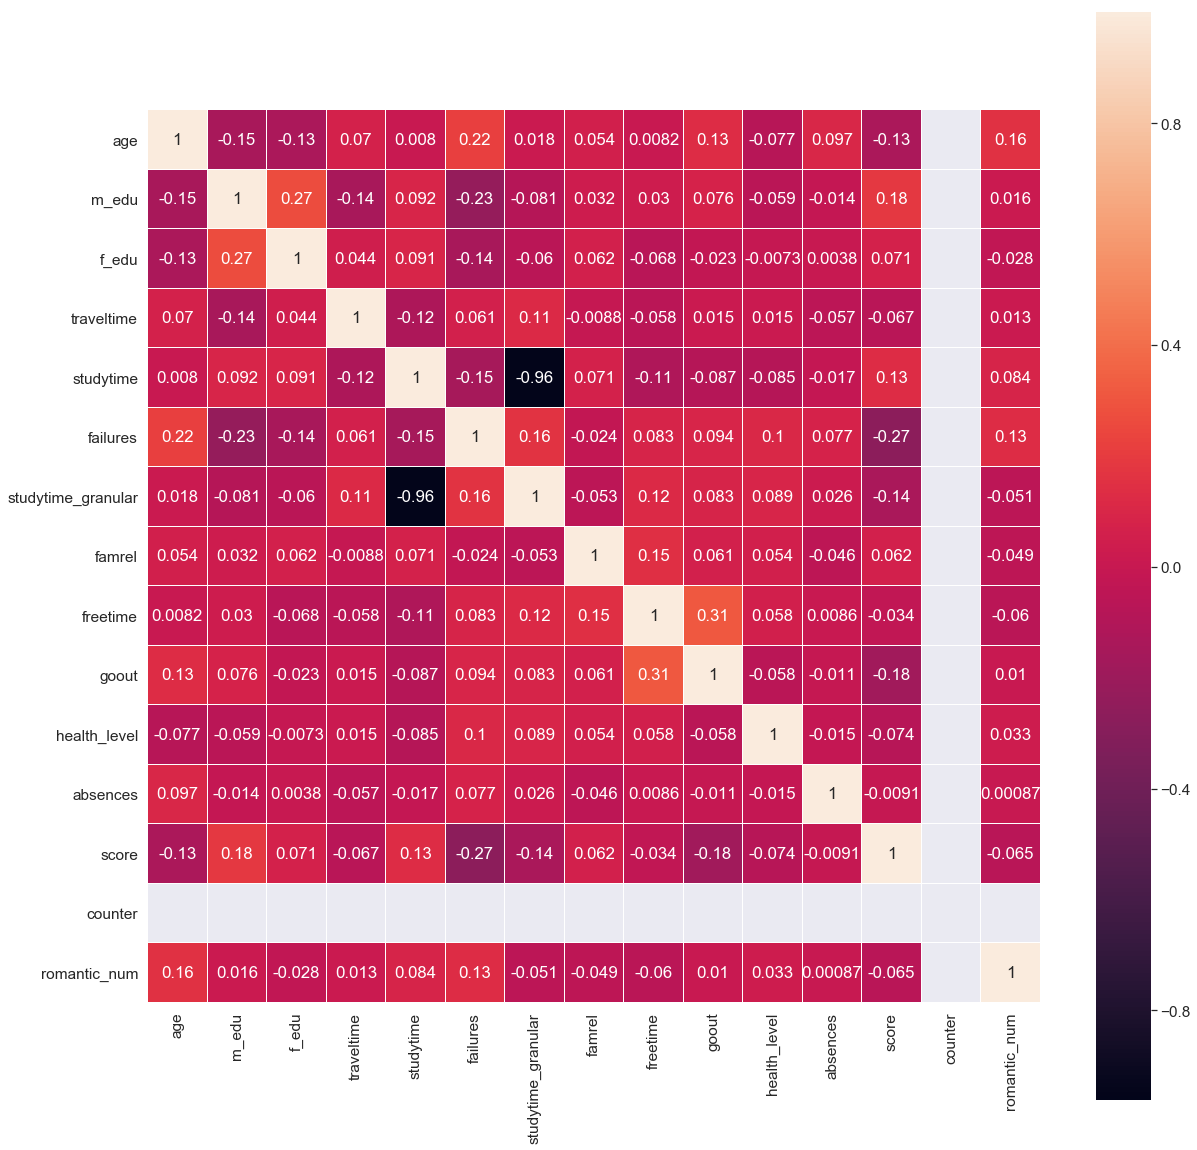

In [1126]:
plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), square=True, annot=True, linewidths=0.1)

In [1127]:
df.corr()

,age,m_edu,f_edu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health_level,absences,score,counter,romantic_num
age,1.000000,-0.146736,-0.132182,0.070285,0.007966,0.216040,0.018227,0.054047,0.008204,0.126868,-0.076597,0.096628,-0.129108,NaN,0.155696
m_edu,-0.146736,1.000000,0.270754,-0.144422,0.091520,-0.231040,-0.081032,0.032238,0.029717,0.076473,-0.058758,-0.014047,0.183650,NaN,0.016280
f_edu,-0.132182,0.270754,1.000000,0.043648,0.091238,-0.142825,-0.059618,0.061740,-0.067578,-0.022948,-0.007265,0.003762,0.071043,NaN,-0.028016
traveltime,0.070285,-0.144422,0.043648,1.000000,-0.124239,0.060956,0.112156,-0.008835,-0.057895,0.014723,0.014996,-0.056646,-0.066724,NaN,0.012648
studytime,0.007966,0.091520,0.091238,-0.124239,1.000000,-0.151625,-0.960757,0.070888,-0.111311,-0.086572,-0.084503,-0.017062,0.127418,NaN,0.084002
failures,0.216040,-0.231040,-0.142825,0.060956,-0.151625,1.000000,0.162448,-0.023641,0.082929,0.094295,0.103921,0.077195,-0.267285,NaN,0.134162
studytime_granular,0.018227,-0.081032,-0.059618,0.112156,-0.960757,0.162448,1.000000,-0.052776,0.116921,0.083106,0.089120,0.025707,-0.135546,NaN,-0.050952
famrel,0.054047,0.032238,0.061740,-0.008835,0.070888,-0.023641,-0.052776,1.000000,0.145550,0.060797,0.053538,-0.046025,0.061909,NaN,-0.048807
freetime,0.008204,0.029717,-0.067578,-0.057895,-0.111311,0.082929,0.116921,0.145550,1.000000,0.312535,0.057561,0.008603,-0.033638,NaN,-0.059698
goout,0.126868,0.076473,-0.022948,0.014723,-0.086572,0.094295,0.083106,0.060797,0.312535,1.000000,-0.058238,-0.010659,-0.178002,NaN,0.010315


Переменные studytime и studytime, granular скоррелированы полностью.

Также видно, что две переменные m_edu и f_edu тоже сильно скоррелированы. Думаю, что одну из них исключать не нужно, т.к. вместе они могут оказать более существенное влияние на целевую переменную

C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\an.ivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


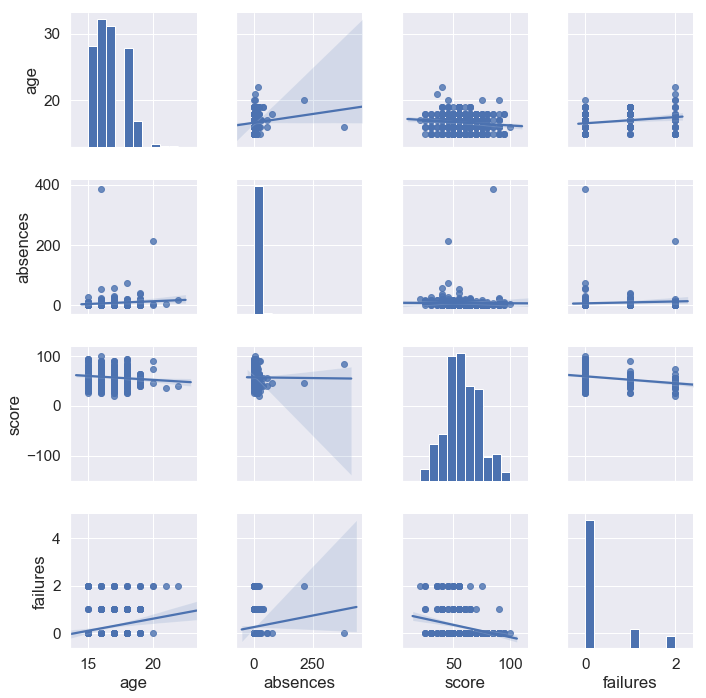

In [1128]:
df_num = df[['age', 'absences', 'score', 'failures']]
sns.pairplot(df_num, kind='reg')

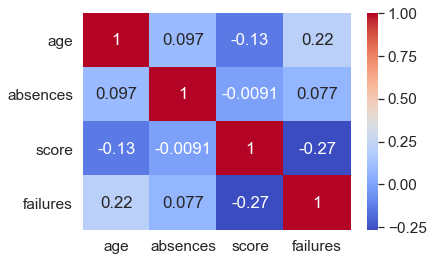

In [1129]:
#Используем для наглядности матрицу корреляций численных показателей, состоящих из исходных данных:
df_corr = df[['age', 'absences', 'score', 'failures']].corr()
sns.heatmap(df_corr, annot=True, cmap= 'coolwarm')

Для сравнения с исходными данными без устранения выбросов, продублируем исходный датафрейм и проведём корреляционный анализ для него.

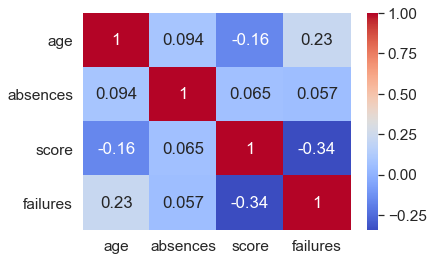

In [1131]:
prim_df = pd.read_csv('stud_math.xls')
prim_df.columns = ['school', 'sex', 'age', 'address', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health_level', 'absences', 'score']

#Используем для наглядности матрицу корреляций численных показателей, состоящих из исходных данных:
prim_df_corr = prim_df[['age', 'absences', 'score', 'failures']].corr()
sns.heatmap(prim_df_corr, annot=True, cmap= 'coolwarm')

Итак, для дальнейшего построения модели в датасете оставим важные переменные, которые, возможно, оказывают влияние на баллы по экзамену, это: age, sex, address, m_edu, f_edu, m_job, studytime, failurs, schoolsup, goout, absences

# Основные выводы

чем образованнее родители ученика, тем лучше его результаты
важное значение имеет профессия родителей
время на учёбу помимо школы оказывает влияние на предсказываемую величину
чем больше у учеников свободного времени, тем больше времени они проводят с друзьями, особенно мальчики
девочки более романтичные особы, чем мальчики